In [1]:
import os
import sys
sys.path.append("/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/pix2pixHD") # access submodules
sys.path = [p for p in sys.path if not p.startswith('/local/scratch') or p.startswith('/local/scratch/js2173')]

In [2]:
from data.data_loader import CreateDataLoader
from models.models import create_model

from options.train_options import TrainOptions
from options.test_options import TestOptions
import util.util as util

In [3]:
import numpy as np
# for testing images in here
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import itertools
%matplotlib inline

In [4]:
opt = TrainOptions()
print(sys.argv)
tmp = sys.argv
sys.argv = [tmp[0]]
opt = opt.parse()
sys.argv = tmp

opt.instance_feat = True # put in features to steer generation
opt.name = 'label2city_512p_feat'
opt.dataroot = '/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/pix2pixHD/datasets/cityscapes/'
opt.checkpoints_dir = '/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/pix2pixHD/checkpoints/'
opt.results = '/local/scratch/js2173/pytorch/Selectively-Retexuring-Subimages/submodules/pix2pixHD/results/'
opt.no_flip = True

# get the features 
subdir_name = 'model_cos_retrain_10iter_lr0.00025'

# get test images
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()



['/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '-f', '/run/user/3879/jupyter/kernel-e5d3b0a6-f36e-4368-8299-ccedee16e233.json']
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
cos_decay: False
cos_decay_update_iters: 100
dataroot: ./datasets/cityscapes/
debug: False
display_freq: 100
display_winsize: 512
feat_num: 3
fineSize: 512
gpu_ids: [0]
instance_feat: False
isTrain: True
label_feat: False
label_nc: 35
lambda_feat: 10.0
loadSize: 1024
load_features: False
load_pretrain: 
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
nef: 16
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_instance: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
p

In [5]:
labels = {
0: 'unlabeled',
1: 'ego vehicle',
2: 'rectification border',
3: 'out of roi',
4:'static',
5:'dynamic' ,
6:'ground',
7:'road',
8:'sidewalk',
9:'parking',
10:'rail track',
11: 'building',
12:'wall',
13:'fence',
14:'guard rail',
15:'bridge',
16:'tunnel',
17:'pole',
18:'polegroup',
19:'traffic light',
20:'traffic sign',
21:'vegetation',
22:'terrain',
23:'sky',
24:'person',
25:'rider',
26:'car',
27:'truck',
28:'bus',
29:'caravan',
30:'trailer',
31:'train',
32:'motorcycle',
33:'bicycle',
-1: 'license plate'
}

lab_to_id = { 
'unlabeled' : 0 ,
 'ego vehicle' : 1 ,
 'rectification border' : 2 ,
 'out of roi' : 3 ,
'static' : 4 ,
'dynamic'  : 5 ,
'ground' : 6 ,
'road' : 7 ,
'sidewalk' : 8 ,
'parking' : 9 ,
'rail track' : 10 ,
 'building' : 11 ,
'wall' : 12 ,
'fence' : 13 ,
'guard rail' : 14 ,
'bridge' : 15 ,
'tunnel' : 16 ,
'pole' : 17 ,
'polegroup' : 18 ,
'traffic light' : 19 ,
'traffic sign' : 20 ,
'vegetation' : 21 ,
'terrain' : 22 ,
'sky' : 23 ,
'person' : 24 ,
'rider' : 25 ,
'car' : 26 ,
'truck' : 27 ,
'bus' : 28 ,
'caravan' : 29 ,
'trailer' : 30 ,
'train' : 31 ,
'motorcycle' : 32 ,
'bicycle' : 33 ,
 'license plate' : -1
}

In [6]:
def fit_polynomial(data, order=3):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]

    # Fit a 3rd order, 2d polynomial
    m = polyfit2d(x,y,z, order=order)

    # Evaluate it on a grid...
    nx, ny = 20, 20
    xx, yy = np.meshgrid(np.linspace(x.min(), x.max(), nx), 
                         np.linspace(y.min(), y.max(), ny))
    zz = polyval2d(xx, yy, m)
    return (xx, yy, zz)


def plot_3D(xs, ys, z, ax=None, color='blue'):
    if ax is None:
        fig = plt.figure(1, figsize=(20,10))
        ax = Axes3D(fig)
    for pt in zip(xs, ys, z):
        ax.scatter(*pt, color=color)
#     # Plot
#     plt.imshow(z, extent=(xx_grid.min(), yy_grid.max(), xx_grid.max(), yy_grid.min()))
#     plt.scatter(xx_grid, yy_grid, c=z)
#     plt.show()

def polyfit2d(x, y, z, order=3):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

In [7]:
# for testing, get the cluster centers
saved_features = os.path.join(opt.checkpoints_dir, opt.name, subdir_name, 'features.npy') 
features_clustered = np.load(os.path.join(opt.checkpoints_dir, opt.name, subdir_name, 'features_clustered_010.npy')).item()
features = np.load(saved_features).item()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


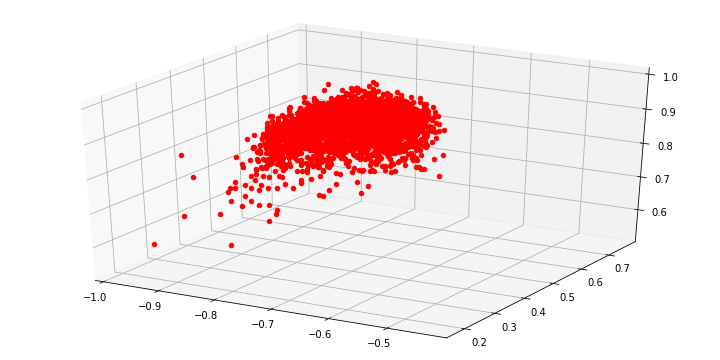

In [8]:
a_features = features[7]
fitted = fit_polynomial(a_features, order=4)

%matplotlib notebook

fig = plt.figure(1, figsize=(10,5))
axis = Axes3D(fig)
#plot_3D(*fitted, ax=axis, color='blue')
plot_3D(*a_features.T[:3], ax=axis, color='red')
plt.show()

<IPython.core.display.Javascript object>


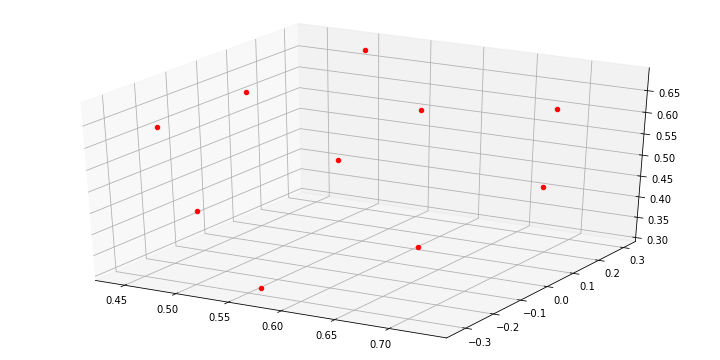

ROAD
[[ 0.49919945  0.30291461  0.67562501]
 [ 0.47284809 -0.19627242  0.42321733]
 [ 0.59871017  0.12528664  0.6147836 ]
 [ 0.56447365 -0.03833458  0.5308287 ]
 [ 0.67227091 -0.16242054  0.4041991 ]
 [ 0.73101064  0.05124125  0.50386027]
 [ 0.69856785  0.23059027  0.62205636]
 [ 0.44244906  0.08772561  0.61502474]
 [ 0.45162335 -0.23639852  0.62316984]
 [ 0.56856726 -0.32151435  0.3162304 ]]
(10, 3)


In [27]:
#print(features)
%matplotlib notebook

fig2 = plt.figure(1, figsize=(10,5))
ax2 = Axes3D(fig2)

classes = ['road']#, 'building']
colors = ['red', 'green', 'blue']
for (i, cat) in enumerate(classes):
    class_id = lab_to_id[cat]
    points = features_clustered[class_id]
    plot_3D(*points.T[:3], ax=ax2, color='red')
    print(cat.upper())
    print(points)
    print(points.shape)
        

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')

plt.show()